# Discrete Data + Probability
### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

### Wrangle

In [2]:
#acquire
colnames=['ip', 'timestamp', 'request_method', 'status', 'size', 'destination', 'request_agent']

df_orig = pd.read_csv('http://python.zach.lol/access.log', 
                      engine='python', 
                      header=None, 
                      index_col=False, 
                      names=colnames, 
                      sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])', 
                      na_values='"-"', 
                      usecols=[0, 3, 4, 5, 6, 7, 8])

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [4]:
#prepare: timestamp values need to be cleaned by removing the brackets and extraneous tail
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.head(2)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [5]:
#replace the first colon in timestamp before year to accomodate for pandas datetime
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

#reset index to timestamp
df = df.set_index('timestamp')

df.head(2)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [6]:
#clean up strings in columns with extra quotes (remove them/replace them w/ nothing)
for col in ['request_method', 'request_agent', 'destination']: 
    df[col] = df[col].str.replace('"', '')
    
#shorten values in request method and clean up by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
#add variable - converting bytes to mb:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


### Detecting Anomalies in Discrete Variables:
#### Finding anomalies in already existing data

In [9]:
#get the value counts of request_method in the dataset
pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index()

,index,request_method
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [10]:
#resetting index 
reqm_df = df.request_method.value_counts(dropna=False).reset_index()\
                .rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_count'})

reqm_df.head()

,request_method,rm_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100


In [11]:
#get the probability of request_method in the dataset
#divide value counts by count to get proba
reqm_df2 = (df.request_method.value_counts(dropna=False) / df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'reqm_proba'})

reqm_df2.head()

,request_method,reqm_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154


In [12]:
#merge/join the two dfs together (reqm_df and reqm_df2)
reqm_df = reqm_df.merge(reqm_df2)
reqm_df.head()

,request_method,rm_count,reqm_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


In [14]:
#compare shape of original df
df.shape, reqm_df.shape

((13978, 7), (22, 3))

In [15]:
#alter the reqm_df to see only those where rate < 1% 
reqm_df[reqm_df.reqm_proba < .01]
reqm_df

,request_method,rm_count,reqm_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


22
                                  request_method  rm_count  reqm_proba
12               GET /api/v1/itemsitems HTTP/1.1         3    0.000215
13                    GET /api/v1/sales/HTTP/1.1         3    0.000215
14                     GET /api/v1items HTTP/1.1         2    0.000143
15                  GET /api/V1/HiZach! HTTP/1.1         1    0.000072
16                          GET /api/v1 HTTP/1.1         1    0.000072
17        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1         1    0.000072
18  GET /api/v1//api/v1/items/next_page HTTP/1.1         1    0.000072
19             GET /api/v1/items&page=0 HTTP/1.1         1    0.000072
20              GET /api/v1/helloclass! HTTP/1.1         1    0.000072
21                    GET /api/v1/items/HTTP/1.1         1    0.000072


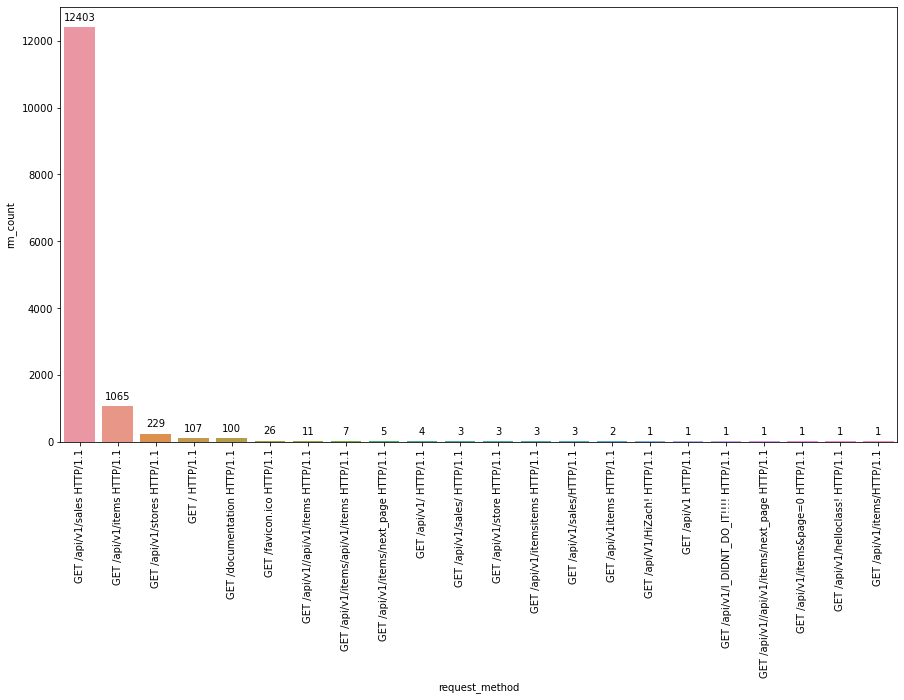

In [19]:
#look for anomalies 
print(len(reqm_df))

print(reqm_df.tail(10))

plt.figure(figsize=(15, 8))
splot = sns.barplot(data=reqm_df, x = 'request_method', y = 'rm_count', ci = None)

#annotate bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points')
plt.xticks(rotation='vertical')
plt.show()

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.

In [20]:
#establish baseline and create train set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

#set train columns
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]
train.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [21]:
#check train size
train.size/df.size

0.9997138360280441

In [22]:
#compute probabilities based on train sample
reqm_df = pd.DataFrame(train.request_method.value_counts(dropna=False) / train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

reqm_df

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156
5,GET /favicon.ico HTTP/1.1,0.001861
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [23]:
#merge proabilities with all data (train + new data): 
#where the request_method is new, (not seen in training set), fill the prob with a value of zero

df = df.reset_index().merge(reqm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.rm_proba.value_counts()

df

,ip,request_method,status,size,destination,request_agent,size_mb,rm_proba
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.887577
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.887577
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.887577
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.887577
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,0,python-requests/2.21.0,0.486532,0.887577
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.000000
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.000000
